In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD



In [3]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/irm-images-adni-adcnmci')):
    subfolder_path = os.path.join('/kaggle/input/irm-images-adni-adcnmci', subfolder)
    for folder in os.listdir(subfolder_path):
        # subfolder_path2=os.path.join(subfolder_path,folder)
        # for image_filename in os.listdir(subfolder_path2):
        image_path = os.path.join(subfolder_path, folder)
        images.append(image_path)
        labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


image label
0      /kaggle/input/irm-images-adni-adcnmci/MCI/I200...   MCI
1      /kaggle/input/irm-images-adni-adcnmci/MCI/I468...   MCI
2      /kaggle/input/irm-images-adni-adcnmci/MCI/I137...   MCI
3      /kaggle/input/irm-images-adni-adcnmci/MCI/I263...   MCI
4      /kaggle/input/irm-images-adni-adcnmci/MCI/I569...   MCI
...                                                  ...   ...
15326  /kaggle/input/irm-images-adni-adcnmci/CN/I3997...    CN
15327  /kaggle/input/irm-images-adni-adcnmci/CN/I4766...    CN
15328  /kaggle/input/irm-images-adni-adcnmci/CN/I1571...    CN
15329  /kaggle/input/irm-images-adni-adcnmci/CN/I7109...    CN
15330  /kaggle/input/irm-images-adni-adcnmci/CN/I2368...    CN

[15331 rows x 2 columns]

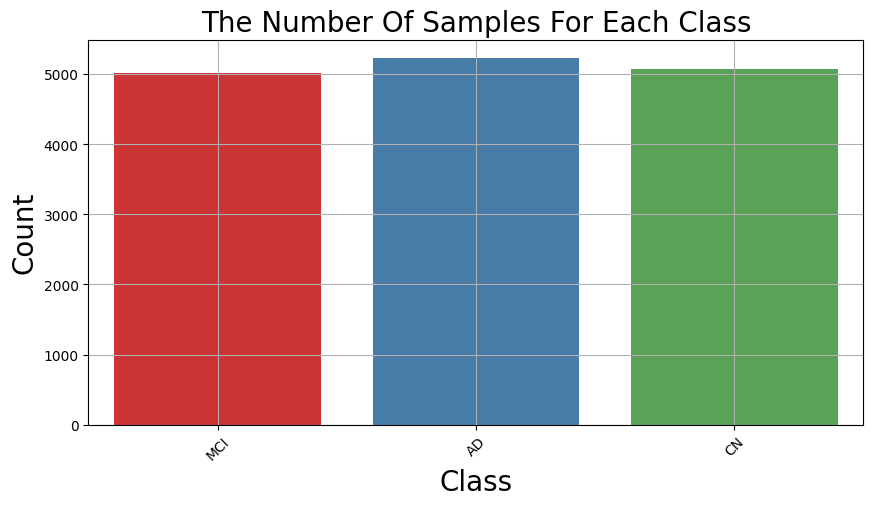

In [4]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

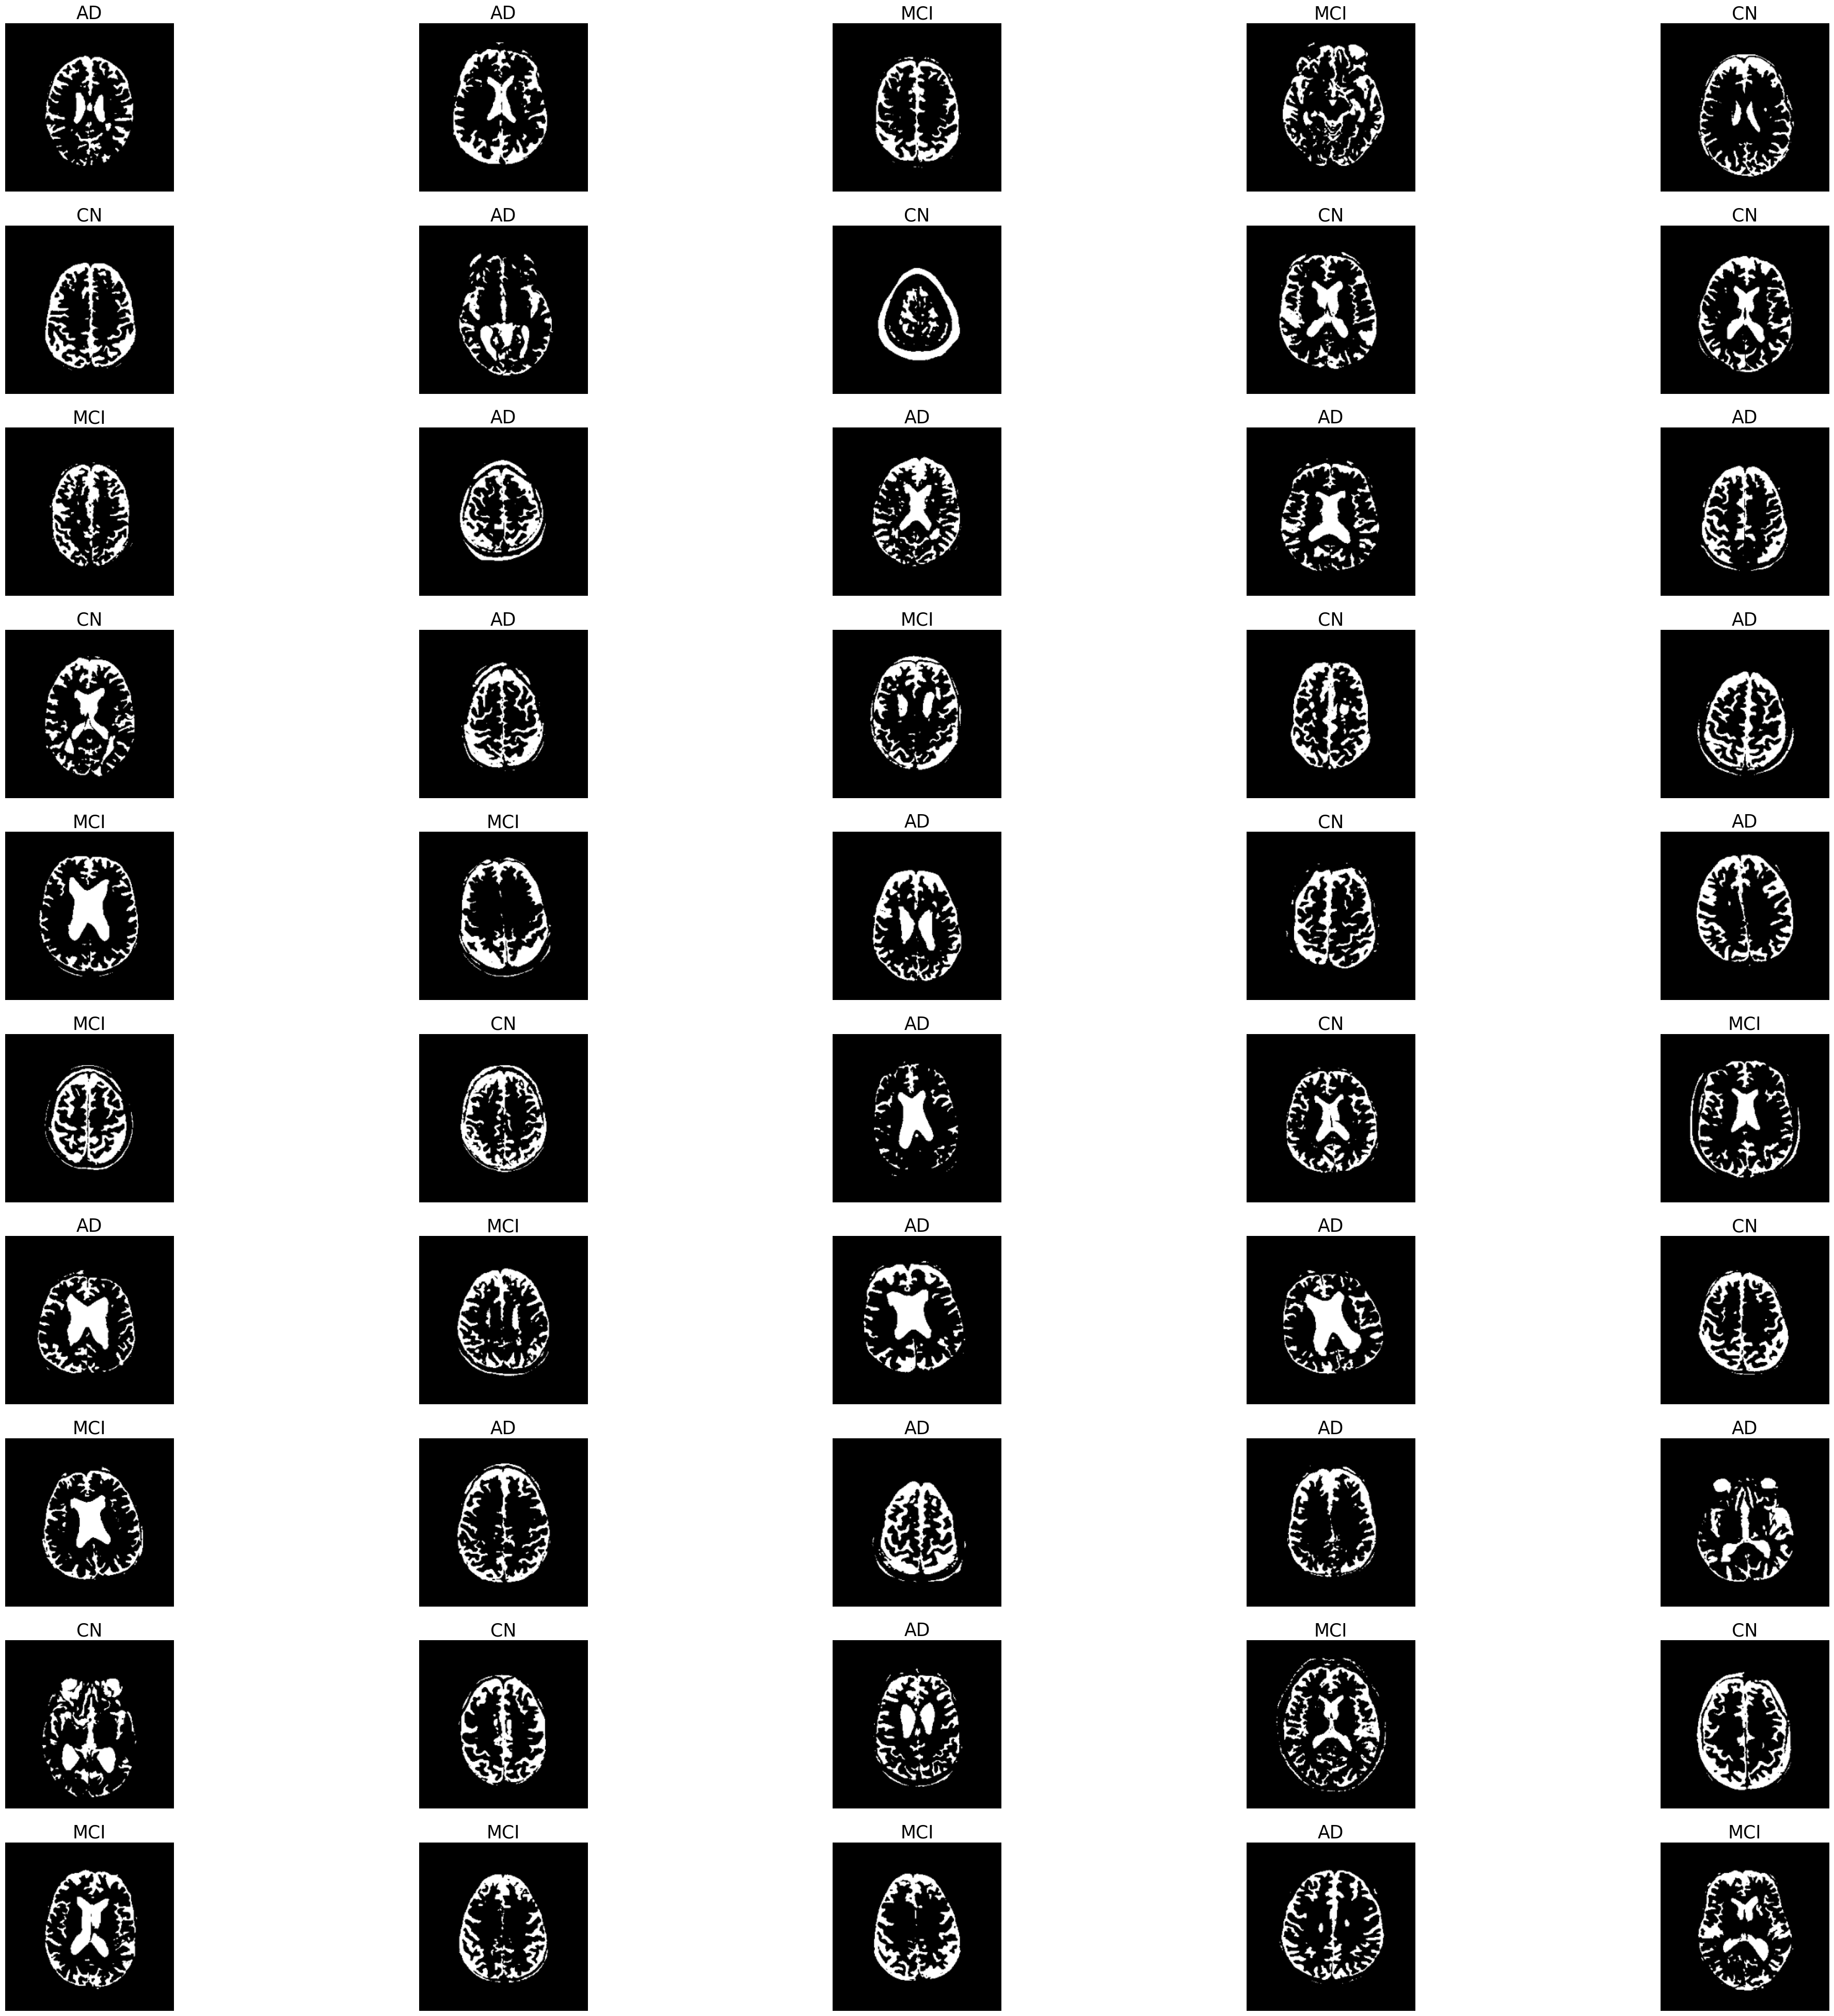

In [5]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [9]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [10]:
X_train.shape

(12264,)

In [11]:
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rescale=1./255,
    # horizontal_flip=True,
    rotation_range=10,        # Utiliser une petite plage de rotation
    width_shift_range=0.1,    # Décalage horizontal modéré
    height_shift_range=0.1,   # Décalage vertical modéré
    # shear_range=0.1,          # Cisaillement modéré
#     zoom_range=0.1,           # Zoom modéré
    # brightness_range=[0.8, 1.2], # Variation de luminosité
    fill_mode='nearest'       # Méthode de remplissage des pixels générés

    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 12264 validated image filenames belonging to 3 classes.
Found 1534 validated image filenames belonging to 3 classes.
Found 1533 validated image filenames belonging to 3 classes.


In [23]:
class_num=list(train_generator.class_indices.keys())
class_num

['AD', 'CN', 'MCI']

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Input
from tensorflow.keras.models import Model

# Charger les poids manuellement
weights_path = '/kaggle/input/weight-vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(input_shape=(224,224,3), include_top=False, pooling='avg', weights=None)
base_model.load_weights(weights_path)

# Créez un modèle fonctionnel
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Assurez-vous que base_model ne soit pas en mode entraînement
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu')(x)
# x = Dropout(0.5)(x)  # Ajouter Dropout si nécessaire
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)  # Ajouter Dropout si nécessaire
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,880,899 (68.21 MB)

 Trainable params: 17,873,731 (68.18 MB)

 Non-trainable params: 7,168 (28.00 KB)

In [13]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Utilisation de l'optimiseur SGD avec un taux d'apprentissage plus bas et de la momentum
optimizer = SGD(learning_rate=0.001, momentum=0.9)

checkpoint_cb = ModelCheckpoint("model_VGG16.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)  # Augmenter la patience

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-28 12:40:28.958127: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-07-28 12:40:28.958187: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-07-28 12:40:28.958197: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-07-28 12:40:28.958205: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-07-28 12:40:28.958213: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

  1/384 ━━━━━━━━━━━━━━━━━━━━ 4:36:15 43s/step - accuracy: 0.4062 - loss: 1.2658

I0000 00:00:1722170463.319994     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


203/384 ━━━━━━━━━━━━━━━━━━━━ 1:33 518ms/step - accuracy: 0.3705 - loss: 1.3284

2024-07-28 12:42:48.948425: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.39009, expected 3.53025
2024-07-28 12:42:48.948478: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.40727, expected 4.54742
2024-07-28 12:42:48.948489: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.56026, expected 4.70042
2024-07-28 12:42:48.948497: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 5.58812, expected 4.72827
2024-07-28 12:42:48.948505: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.9643, expected 4.10445
2024-07-28 12:42:48.948512: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 5.19898, expected 4.33914
2024-07-28 12:42:48.948520: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.47066, expected 4.61082
2024-07-28 12:42:48.948527: 

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.3774 - loss: 1.2737

2024-07-28 12:44:58.472568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.5554, expected 3.07265
2024-07-28 12:44:58.472637: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13778, expected 2.65504
2024-07-28 12:44:58.472652: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.34289, expected 2.86015
2024-07-28 12:44:58.472666: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 181: 3.72137, expected 3.23862
2024-07-28 12:44:58.472683: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 198: 3.32536, expected 2.84261
2024-07-28 12:44:58.472698: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 199: 3.81774, expected 3.335
2024-07-28 12:44:58.472709: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 223: 2.84685, expected 2.36411
2024-07-28 12:44:58.472743: E external/local_xla

384/384 ━━━━━━━━━━━━━━━━━━━━ 291s 647ms/step - accuracy: 0.3774 - loss: 1.2735 - val_accuracy: 0.3418 - val_loss: 1.6201
Epoch 2/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 154s 394ms/step - accuracy: 0.4497 - loss: 1.0588 - val_accuracy: 0.3431 - val_loss: 2.6800
Epoch 3/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 154s 394ms/step - accuracy: 0.4642 - loss: 1.0469 - val_accuracy: 0.3372 - val_loss: 4.0635
Epoch 4/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 155s 398ms/step - accuracy: 0.4630 - loss: 1.0511 - val_accuracy: 0.3405 - val_loss: 1.5211
Epoch 5/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 153s 391ms/step - accuracy: 0.4831 - loss: 1.0213 - val_accuracy: 0.3470 - val_loss: 2.5509
Epoch 6/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 155s 396ms/step - accuracy: 0.5089 - loss: 0.9918 - val_accuracy: 0.4070 - val_loss: 1.3739
Epoch 7/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 155s 396ms/step - accuracy: 0.5340 - loss: 0.9615 - val_accuracy: 0.4351 - val_loss: 1.2161
Epoch 8/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 155s 396ms/step - accuracy: 0.5462 - los

In [14]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0   0.394977  1.184417      0.341813  1.620093
1   0.447162  1.058695      0.343118  2.679969
2   0.467384  1.040085      0.337247  4.063477
3   0.469830  1.044011      0.340509  1.521094
4   0.483692  1.018884      0.347032  2.550934
5   0.508806  0.988499      0.407045  1.373910
6   0.532942  0.968802      0.435095  1.216139
7   0.563193  0.923678      0.341161  1.742193
8   0.588633  0.896387      0.480757  1.782302
9   0.631360  0.824615      0.341813  6.995240
10  0.674576  0.760668      0.341161  5.961552
11  0.715101  0.687480      0.356164  2.375873
12  0.750489  0.609347      0.369863  2.320030
13  0.780577  0.544769      0.489237  2.351532
14  0.816128  0.466146      0.688193  0.807695
15  0.848010  0.390360      0.559687  1.741682
16  0.861546  0.359669      0.675799  0.909977
17  0.883888  0.300413      0.536856  2.932188
18  0.897913  0.271810      0.626223  0.970700
19  0.917808  0.218747      0.370515  3.648623
20  0.928408  0.194792      0.495108  2.305521
21  0.943249  0.150102      0.739074  0.892284
22  0.943819  0.149148      0.654273  1.368725
23  0.953196  0.124910      0.818656  0.481796
24  0.954012  0.124150      0.681018  1.261943
25  0.965672  0.095886      0.824527  0.518260
26  0.962084  0.104555      0.637965  1.531165
27  0.968118  0.090187      0.776256  0.922304
28  0.972521  0.076491      0.697978  1.285865
29  0.971543  0.078293      0.839530  0.706734
30  0.970809  0.083548      0.649706  1.802503
31  0.974152  0.072562      0.801696  0.762273
32  0.973418  0.075504      0.775603  0.809710
33  0.980349  0.056520      0.690802  1.351356
34  0.980431  0.057519      0.818656  0.709214
35  0.980838  0.053194      0.829746  0.568603
36  0.979860  0.054530      0.686236  1.355295
37  0.985731  0.041916      0.879322  0.336386
38  0.984508  0.041810      0.695369  1.196684
39  0.985894  0.041239      0.832355  0.617311
40  0.986546  0.039600      0.851924  0.522295
41  0.991357  0.027085      0.900196  0.396931
42  0.988177  0.033551      0.833007  0.558290
43  0.989481  0.031525      0.718200  1.017851
44  0.989971  0.030147      0.686888  1.266760
45  0.987606  0.034200      0.866275  0.521678
46  0.992172  0.023452      0.854534  0.427762
47  0.991031  0.026063      0.810176  0.671064
48  0.990134  0.028921      0.846706  0.503895
49  0.990868  0.026227      0.800391  0.606305
50  0.995189  0.015379      0.358121  5.002255
51  0.990541  0.027820      0.875408  0.398001
52  0.992743  0.023361      0.843444  0.610284

In [27]:
hist_.to_csv('/kaggle/working/hist_model.csv', index=False)


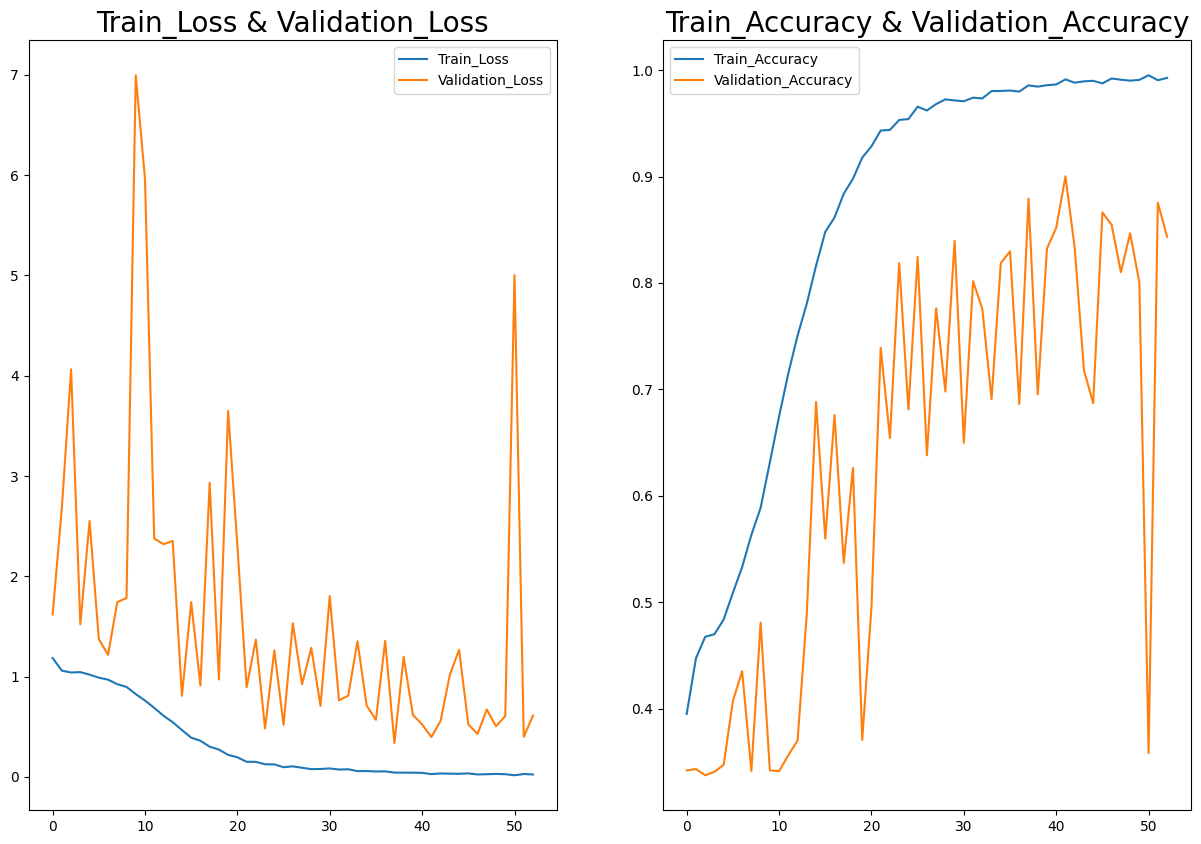

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [16]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.8966 - loss: 0.2711

2024-07-28 15:17:35.562144: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 5.1593, expected 4.2307
2024-07-28 15:17:35.562214: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.27465, expected 4.34605
2024-07-28 15:17:35.562228: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 6.22507, expected 5.29647
2024-07-28 15:17:35.562239: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 6.11698, expected 5.18838
2024-07-28 15:17:35.562254: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.57882, expected 4.65022
2024-07-28 15:17:35.562272: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 5.26032, expected 4.33172
2024-07-28 15:17:35.562285: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.05778, expected 4.12918
2024-07-28 15:17:35.562296: E

48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 858ms/step - accuracy: 0.8960 - loss: 0.2729
Test Loss = 0.31591615080833435
Test Accuracy = 0.8833116292953491


In [17]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 362ms/step


Actual  Prediction
0          2           2
1          0           0
2          2           2
3          2           2
4          1           1
...      ...         ...
1529       0           2
1530       1           1
1531       1           1
1532       0           0
1533       1           1

[1534 rows x 2 columns]

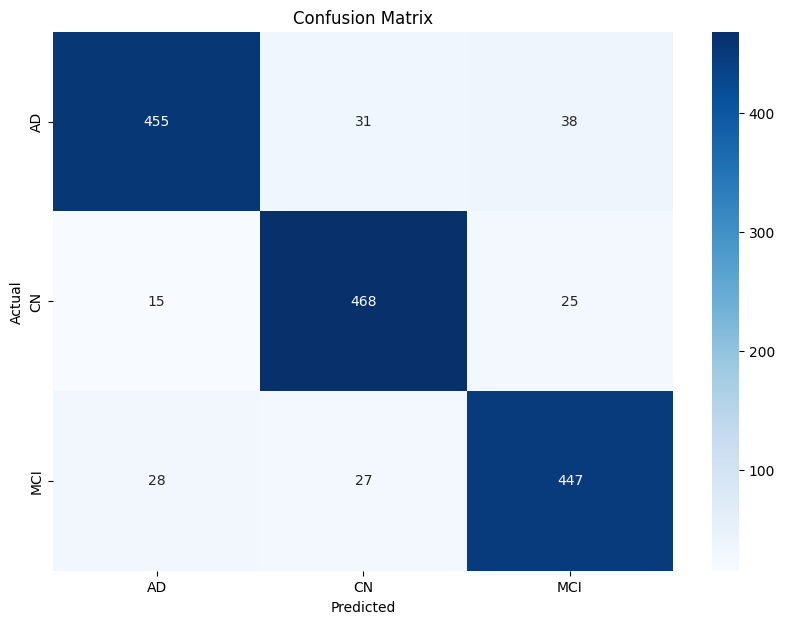

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que class_num soit un dictionnaire de la forme {0: 'Class 1', 1: 'Class 2', 2: 'Class 3'}
# class_num = {0: 'Class 1', 1: 'Class 2', 2: 'Class 3'}

# Obtenez les noms des classes dans l'ordre de leurs étiquettes numériques
class_names = [class_num[i] for i in range(len(class_num))]

# Calculate the confusion matrix
cm = confusion_matrix(df['Actual'], df['Prediction'])

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


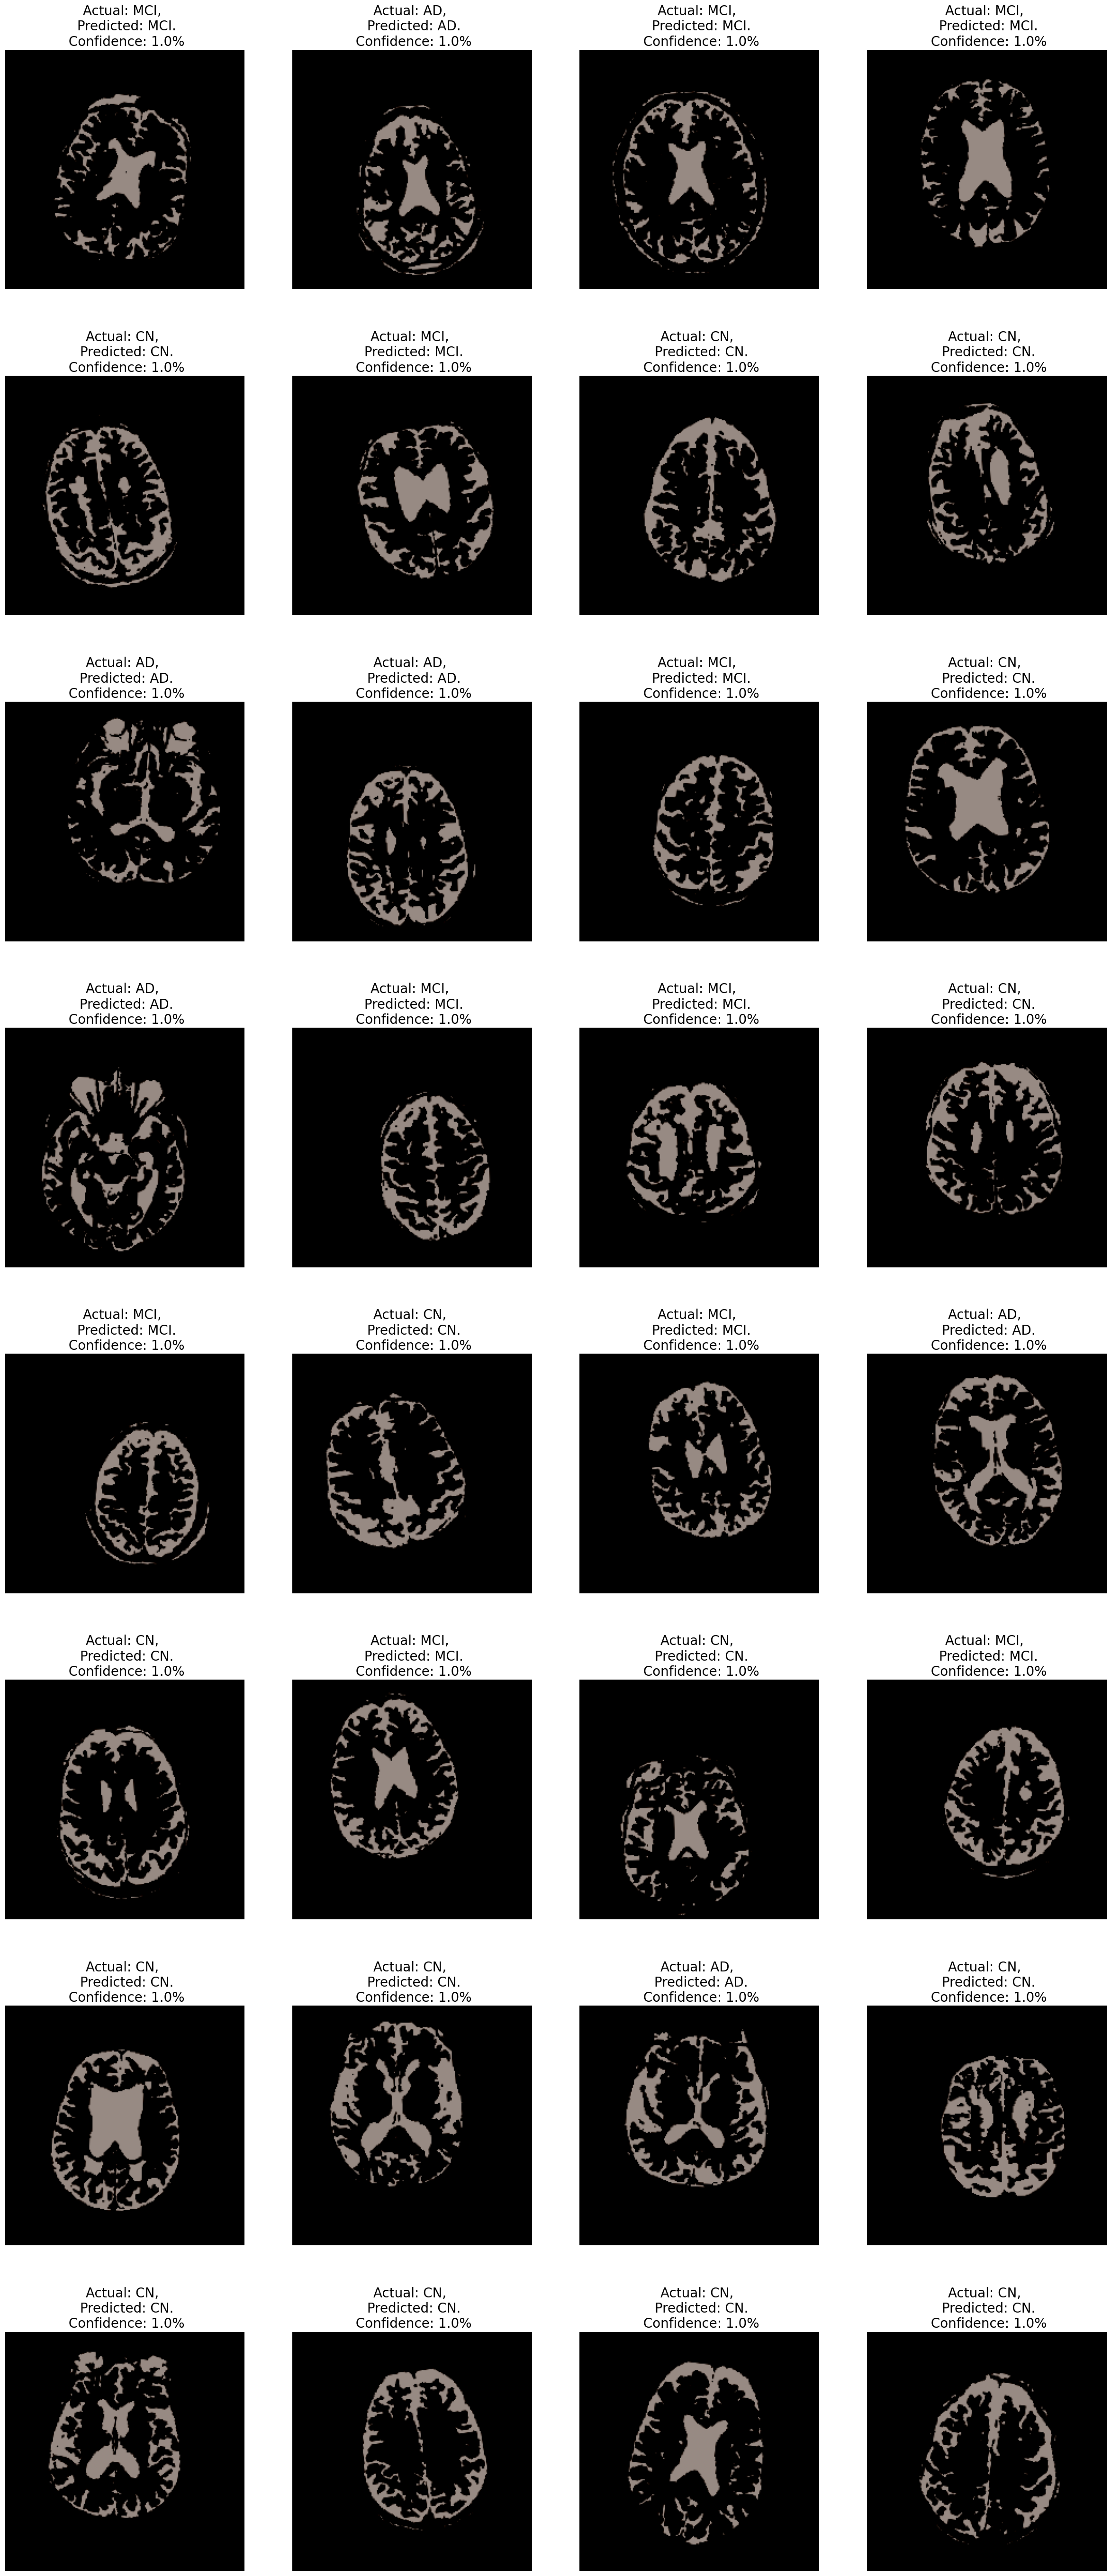

In [25]:
plt.figure(figsize=(30,70))
batch = next(test_generator)
images= batch[0]
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(f"Actual: {class_num[y_test[n]]}, \n Predicted: {class_num[y_pred[n]]}.\n Confidence: {round(predictions[n][np.argmax(predictions[n])],0)}%",fontsize=20)

In [26]:
# Sauvegarder le modèle dans le répertoire de travail
model.save('/kaggle/working/mon_modele_alzheimer.h5')
